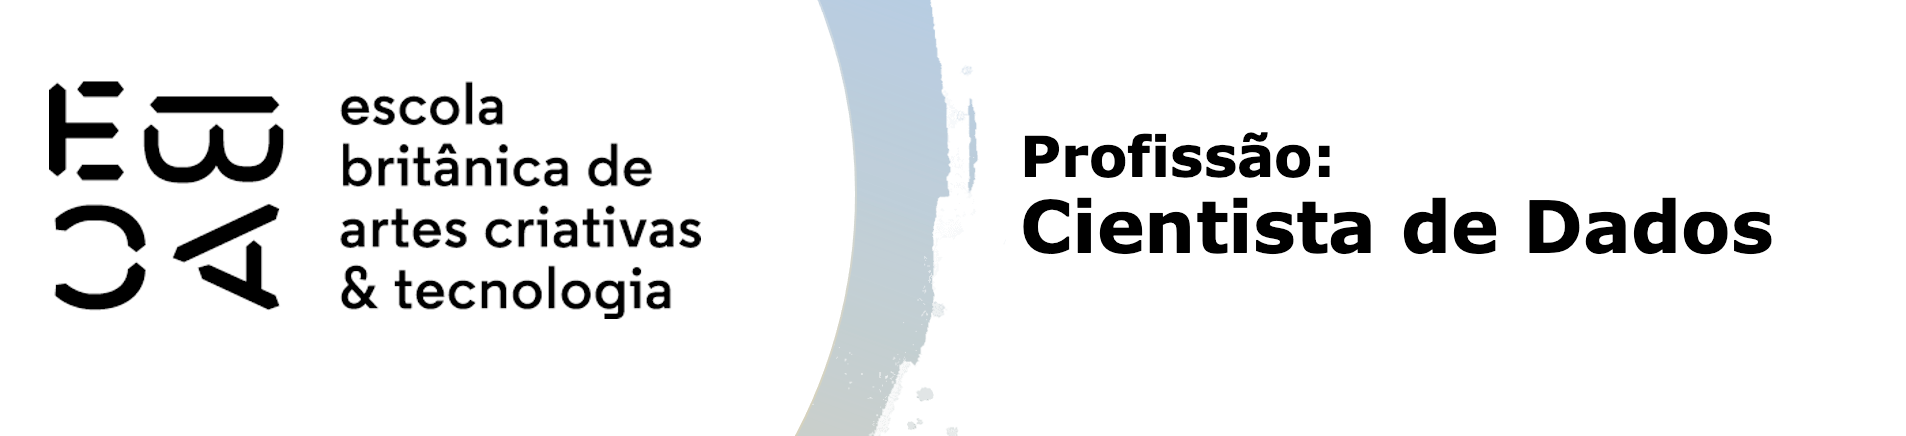

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


- Nesta primeira parte do exercício, iremos usar uma cópia do dataframe original.
- Além disso, iremos repetir o código do exercício passado.


In [4]:
df['mau'] = df['mau'].astype('int64')
df_2 = df.copy()

In [5]:
df_oot = df_2[df_2['data_ref'] > (df_2['data_ref'].max() - pd.DateOffset(months= 3))]
df_test = df_2[~(df_2['data_ref'] > (df_2['data_ref'].max() - pd.DateOffset(months= 3)))]

In [6]:
df_test['tempo_emprego'] = df_test['tempo_emprego'].fillna(df_test['tempo_emprego'].mean())
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(df_oot['tempo_emprego'].mean())

C:\Users\samsun\AppData\Local\Temp\ipykernel_15184\1044575023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['tempo_emprego'] = df_test['tempo_emprego'].fillna(df_test['tempo_emprego'].mean())
C:\Users\samsun\AppData\Local\Temp\ipykernel_15184\1044575023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(df_oot['tempo_emprego'].mean())


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
desc_mes = df_test.groupby(df_test['data_ref'].dt.to_period('M'))['data_ref'].size()
desc_mes

data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Freq: M, Name: data_ref, dtype: int64

In [8]:
# Para fazer uma análise descritiva, iremos primeiramente criar funções pertinentes para isso, serão a de calcular e classificar o IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    # Calcular as proporções
    tab['pct_evento'] = tab[rótulo_evento] / tab.loc['total', rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento] / tab.loc['total', rótulo_nao_evento]

    # Evitar divisão por zero
    tab['woe'] = np.where(tab['pct_nao_evento'] != 0, 
                          np.log(tab['pct_evento'] / tab['pct_nao_evento']),
                          0)

    # Calcular IV parcial
    tab['iv_parcial'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['woe']
    return tab['iv_parcial'].sum()

def cat_iv(iv):
    if iv < 0.02:
        return 'inútil'
    elif iv < 0.1:
        return 'fraca'
    elif iv < 0.3:
        return 'média'
    elif iv < 0.5:
        return 'forte'
    else:
        return 'suspeitamente forte'

In [9]:
df_test[['idade', 'renda', 'tempo_emprego', 'tempo_emprego']].describe()

,idade,renda,tempo_emprego,tempo_emprego
count,600000.000000,6.000000e+05,600000.000000,600000.000000
mean,43.798530,2.722284e+04,7.747992,7.747992
std,11.230659,8.737788e+04,6.100461,6.100461
min,22.000000,1.618600e+02,0.117808,0.117808
25%,34.000000,4.670600e+03,3.635616,3.635616
50%,43.000000,9.887580e+03,7.473973,7.473973
75%,53.000000,2.162887e+04,9.069863,9.069863
max,68.000000,4.083986e+06,42.906849,42.906849


Text(0.5, 1.0, 'Histograma da renda')

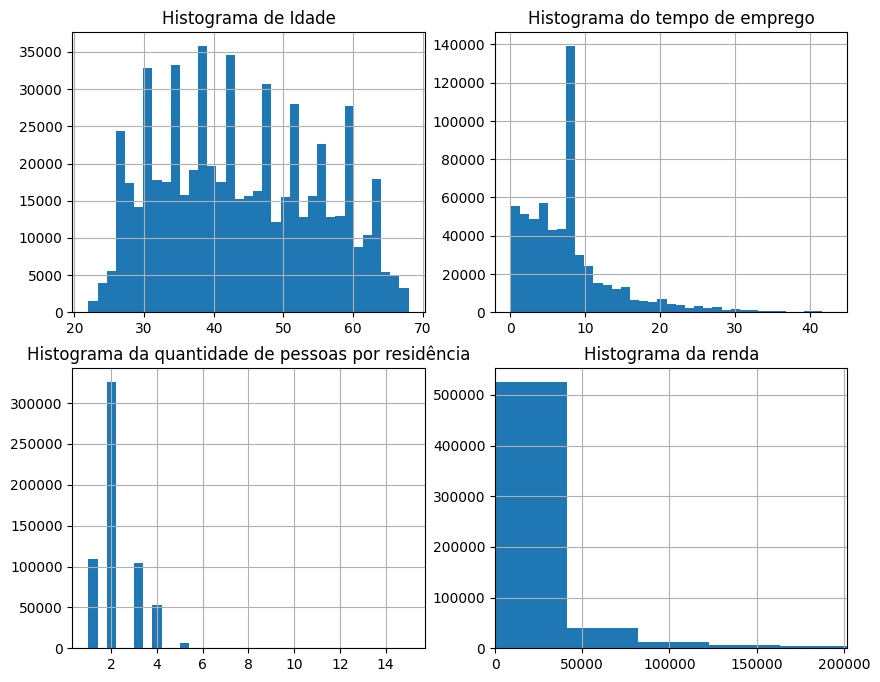

In [11]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))

df_test['idade'].hist(bins=35, ax=axs[0, 0])
axs[0, 0].set_title('Histograma de Idade')

df_test['tempo_emprego'].hist(bins = 35, ax = axs[0,1])
axs[0, 1].set_title('Histograma do tempo de emprego')

df_test['qt_pessoas_residencia'].hist(bins = 35, ax = axs[1,0])
axs[1, 0].set_title('Histograma da quantidade de pessoas por residência')

# Como os valores de renda variam muito, o eixo x mostrará de zero até a média mais o dobro do desvio padrão.
df_test['renda'].hist(bins = 100, ax = axs[1,1])
axs[1, 1].set_xlim(0, df_test['renda'].mean() + (2*df_test['renda'].std()))
axs[1, 1].set_title('Histograma da renda')

In [12]:
df_test[['sexo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'estado_civil']].describe()

,sexo,posse_de_imovel,tipo_renda,educacao,tipo_residencia,estado_civil
count,600000,600000,600000,600000,600000,600000
unique,2,2,5,5,6,5
top,F,S,Assalariado,Médio,Casa,Casado
freq,403805,403054,308460,405449,539336,421149


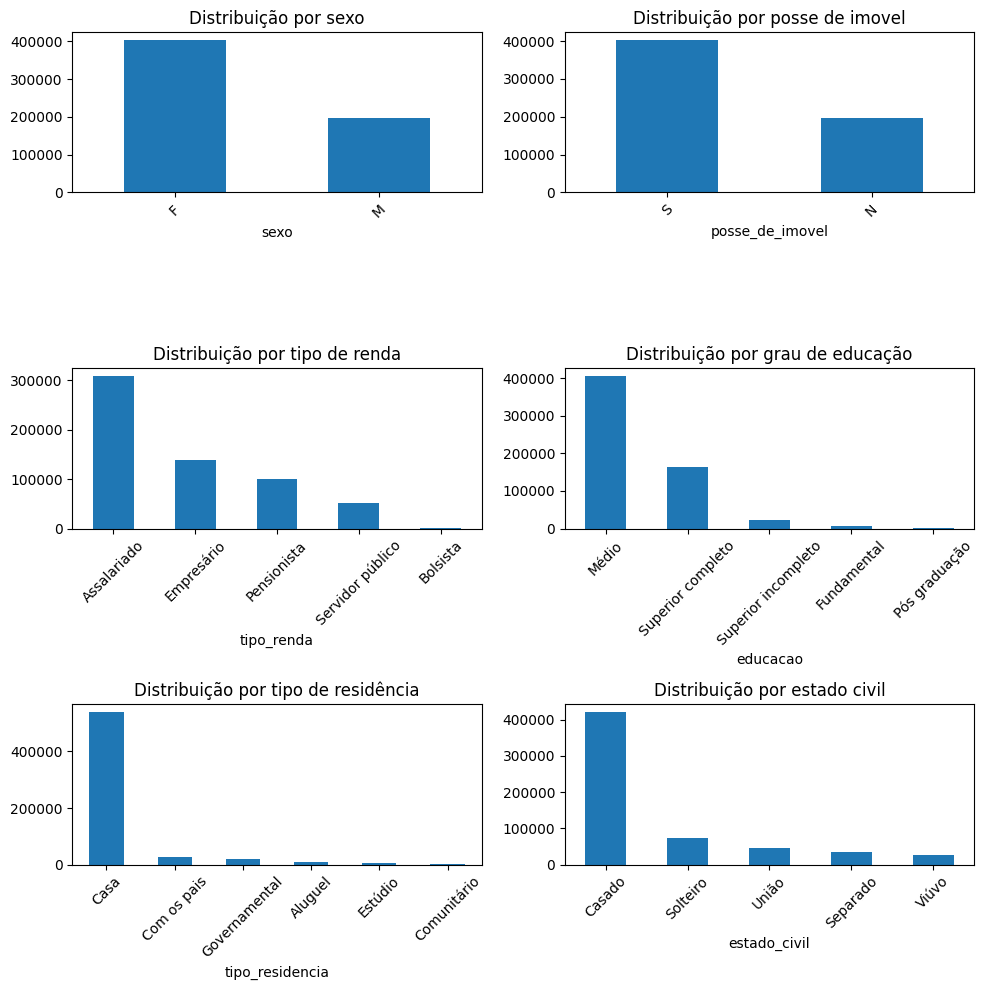

In [13]:
fig, axs = plt.subplots(3,2, figsize=(10, 10))

df_test['sexo'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Distribuição por sexo')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45)

df_test['posse_de_imovel'].value_counts().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Distribuição por posse de imovel')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)

df_test['tipo_renda'].value_counts().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Distribuição por tipo de renda')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45)

df_test['educacao'].value_counts().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Distribuição por grau de educação')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)

df_test['tipo_residencia'].value_counts().plot(kind='bar', ax=axs[2, 0])
axs[2, 0].set_title('Distribuição por tipo de residência')
axs[2, 0].set_xticklabels(axs[2, 0].get_xticklabels(), rotation=45)

df_test['estado_civil'].value_counts().plot(kind='bar', ax=axs[2, 1])
axs[2, 1].set_title('Distribuição por estado civil')
axs[2, 1].set_xticklabels(axs[2, 1].get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [14]:
metadados = pd.DataFrame(df_test.dtypes, columns=['dtype'])
metadados['nmissing'] = df_test.isna().sum()
metadados['valores_unicos'] = df_test.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'


for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_test[var],5,duplicates='drop'), df_test.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_test[var], df_test.mau)
        
metadados['faixa_iv'] = metadados['IV'].apply(lambda iv: cat_iv(iv))
metadados

,dtype,nmissing,valores_unicos,papel,IV,faixa_iv
data_ref,datetime64[ns],0,12,covariavel,0.247065,média
index,int64,0,16650,covariavel,0.002716,inútil
sexo,object,0,2,covariavel,0.002665,inútil
posse_de_veiculo,object,0,2,covariavel,0.000075,inútil
posse_de_imovel,object,0,2,covariavel,0.009690,inútil
qtd_filhos,int64,0,8,covariavel,0.000055,inútil
tipo_renda,object,0,5,covariavel,0.009718,inútil
educacao,object,0,5,covariavel,0.003690,inútil
estado_civil,object,0,5,covariavel,0.001305,inútil
tipo_residencia,object,0,6,covariavel,0.003330,inútil


C:\Users\samsun\AppData\Local\Temp\ipykernel_15184\3298128209.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)
C:\Users\samsun\AppData\Local\Temp\ipykernel_15184\3298128209.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)


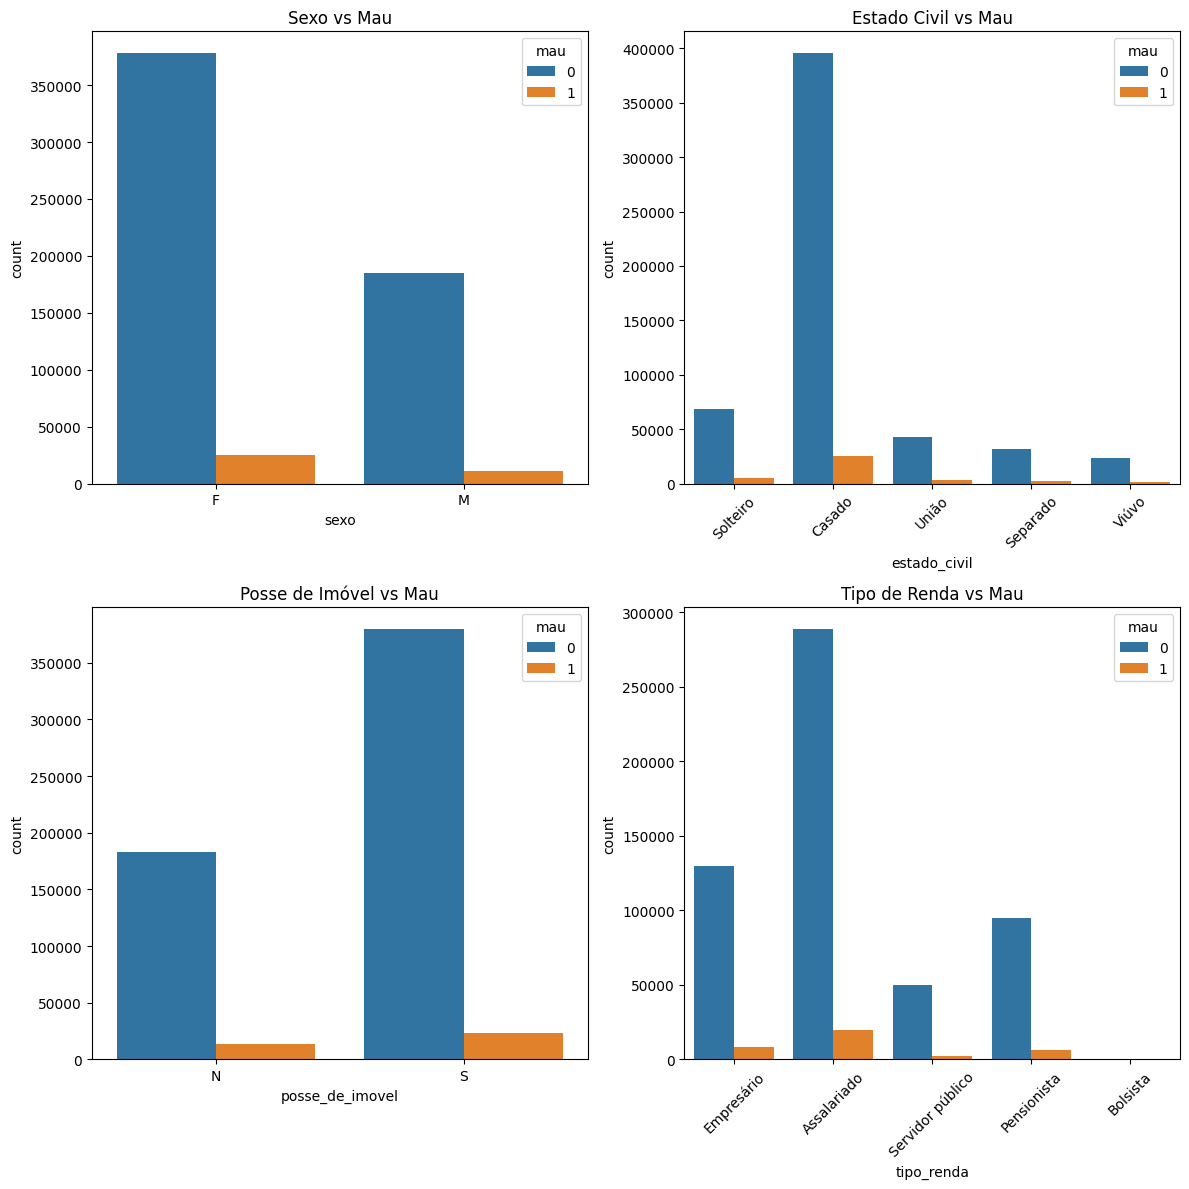

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sns.countplot(x='sexo', hue='mau', data=df_test, ax=axs[0, 0])
axs[0, 0].set_title('Sexo vs Mau')

sns.countplot(x='estado_civil', hue='mau', data=df_test, ax=axs[0, 1])
axs[0, 1].set_title('Estado Civil vs Mau')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)

sns.countplot(x='posse_de_imovel', hue='mau', data=df_test, ax=axs[1, 0])
axs[1, 0].set_title('Posse de Imóvel vs Mau')

sns.countplot(x='tipo_renda', hue='mau', data=df_test, ax=axs[1, 1])
axs[1, 1].set_title('Tipo de Renda vs Mau')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)


plt.subplots_adjust(hspace=0.8)
plt.tight_layout()


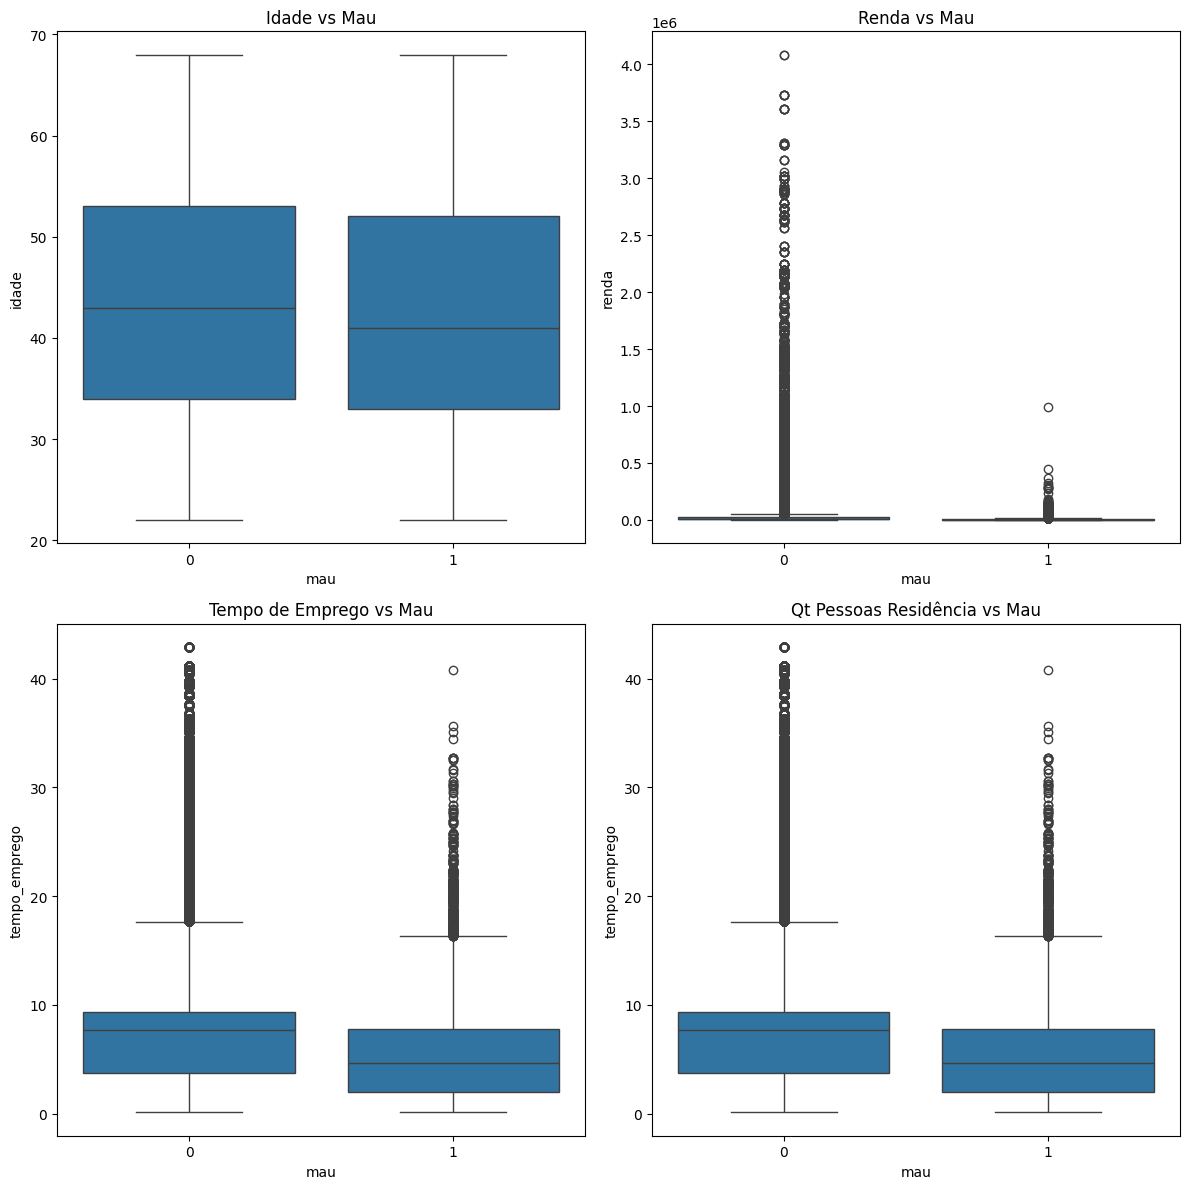

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(x='mau', y='idade', data=df_test, ax=axs[0, 0])
axs[0, 0].set_title('Idade vs Mau')

sns.boxplot(x='mau', y='renda', data=df_test, ax=axs[0, 1])
axs[0, 1].set_title('Renda vs Mau')

sns.boxplot(x='mau', y='tempo_emprego', data=df_test, ax=axs[1, 0])
axs[1, 0].set_title('Tempo de Emprego vs Mau')

sns.boxplot(x='mau', y='tempo_emprego', data=df_test, ax=axs[1, 1])
axs[1, 1].set_title('Qt Pessoas Residência vs Mau')

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
formula = '''mau ~  posse_de_imovel + tipo_renda  + idade + tempo_emprego'''

rl = smf.glm(formula, data=df_test, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599992
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3287e+05
Date:                Tue, 24 Sep 2024   Deviance:                   2.6575e+05
Time:                        18:23:49   Pearson chi2:                 6.00e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01676
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.7355      0.026    -65.946      0.000      -1.787      -1.684
posse_de_imovel[T.S]              -0.2098      0.011    -18.418      0.000      -0.232      -0.187
tipo_renda[T.Bolsista]             0.2322      0.295      0.787      0.432      -0.346       0.811
tipo_renda[T.Empresário]          -0.1465      0.014    -10.705      0.000      -0.173      -0.120
tipo_renda[T.Pensionista]          0.3002      0.020     15.363      0.000       0.262       0.338
tipo_renda[T.Servidor público]    -0.1137      0.023     -4.992      0.000      -0.158      -0.069
idade                             -0.0021      0.001     -3.287      0.001      -0.003      -0.001
tempo_emprego                     -0.1240      0.002    -80.634      0.000      -0.127      -0.121
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [18]:
df_oot['score'] = rl.predict(df_oot)

# Acurácia
acc = metrics.accuracy_score(df_oot.mau, df_oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_oot.loc[df_oot.mau == 1, 'score'], df_oot.loc[df_oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 63.3% 
AUC: 64.7% 
GINI: 29.4%
KS: 20.4%


C:\Users\samsun\AppData\Local\Temp\ipykernel_15184\648990940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oot['score'] = rl.predict(df_oot)


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [19]:
df_test_2 = df_test.drop(columns=['index', 'data_ref'])

In [20]:
# O primeiro passo será substituir valores nan pela média dos valores daquela variável
# Para isso, usaremos o SimpleInputer do scikit-learn

def selecionar_numericas(df):
    return list(df.select_dtypes(include=['int64', 'float64']).columns)

colunas_numericas = selecionar_numericas(df_test_2)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), colunas_numericas)
    ], 
    remainder='passthrough')
preprocessor.set_output(transform= 'pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', SimpleImputer(),
                                 ['qtd_filhos', 'idade', 'tempo_emprego',
                                  'qt_pessoas_residencia', 'renda', 'mau'])])

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [21]:
# Aqui, iremos deletar as linhas onde os valores são maiores que a média mais duas vezes o desvio padrão
# Para isso, criaremos essa função.

def remove_outliers(df, columns):
    for col in columns:
        if col != 'mau':  # Correção aqui
            mean = df[col].mean()
            std = df[col].std()
            upper_limit = mean + 2 * std
            df = df[df[col] <= upper_limit]
    return df

In [22]:
outlier_removal = FunctionTransformer(remove_outliers, kw_args={'columns': colunas_numericas}, validate=False)

In [23]:
# A função acima muda o nome das colunas, portanto, iremos adicionar um passo extra para voltar os nomes ao normal.
def renomear_colunas(df):
    # Remove o prefixo e o sublinhado inicial, retornando apenas o nome original da coluna
    return df.rename(columns=lambda x: x.split('__', 1)[-1])

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [24]:
'''Iremos usar o IV para selecionar variáveis.
Para isso, iremos reaporveitar a função de calcular IV já utilizada.
Iremos criar uma nova função que filtra apenas as variáveis com IV maior que 0,005'''
def filtrar_variaveis_iv(X, threshold=0.005):
    y = X['mau']  
    X_filtrado = X.drop(columns=['mau'])
    variaveis_selecionadas = []

    for col in X_filtrado.columns:
        if X_filtrado[col].nunique() > 6:
            iv = IV(pd.qcut(X_filtrado[col], 5, duplicates='drop'), y)
        else:
            iv = IV(X_filtrado[col], y)

        if iv > threshold:
            variaveis_selecionadas.append(col)

    return X[variaveis_selecionadas + ['mau']]

In [25]:
iv_selector = FunctionTransformer(filtrar_variaveis_iv, validate=False)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [26]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [27]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X deve ser um DataFrame do pandas.")
        
        colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns
        if len(colunas_categoricas) == 0:
            return X
        
        df_dummies = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)
        return df_dummies

In [28]:
dummy_transformer = DummyTransformer()

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [29]:
pipe = Pipeline(steps= [
    ('inputer', preprocessor),
    ('renomear', FunctionTransformer(renomear_colunas, validate=False)),
    ('outliers', outlier_removal),
    ('filter', iv_selector),
    ('dummies', dummy_transformer),
    ('pca', pca_pipe)
])

In [30]:
pipe.fit(df_test_2)

Pipeline(steps=[('inputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', SimpleImputer(),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda', 'mau'])])),
                ('renomear',
                 FunctionTransformer(func=<function renomear_colunas at 0x0000013760FF3BA0>)),
                ('outliers',
                 FunctionTransformer(func=<function remove_outliers at 0x00000137653C98A0>,
                                     kw_args={'columns': ['qtd_filhos', 'idade',
                                                          'tempo_emprego',
                                                          'qt_pessoas_residencia',
                                                          'renda', 'mau']})),
                ('filter',
                 FunctionTransformer(func=<function filtrar_variaveis_iv at 0x00000137653C9940>)),
                ('dummies', DummyTransformer()), ('pca', PCA(n_components=5))])

In [31]:
pipe.transform(df_test_2)

array([[-1.08515483e+04,  6.13891021e-01,  1.87105333e+00,
         3.87208069e-01, -5.74201261e-01],
       [-1.01867490e+04,  8.81263347e+00,  9.76031269e-02,
        -5.47445106e-01, -1.36097236e-01],
       [ 3.54232920e+02, -1.01842847e+01,  5.42771433e+00,
         4.94631064e-01, -4.98890061e-01],
       ...,
       [-8.24976728e+03, -1.82413281e+01,  8.45660511e-01,
         5.75954705e-01, -5.14949069e-01],
       [-1.04814876e+04,  3.12547404e+00,  8.11424104e+00,
         3.46901537e-01, -5.29331384e-01],
       [-9.97128707e+03, -2.23331375e+01,  7.26195406e-01,
        -2.54920311e-01,  3.04973824e-02]])

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [1]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


As operações abaixo foram feitas em um ambiente virtual usando o python versão *3.8.19*, além disso, usou-se o scikit-learn versão *1.2.2* e o pycaret versão *3.2.0*, algumas das funcionalidades vistas abaixo não funcionam perfeitamente em versões mais recentes.

In [2]:
from pycaret.datasets import get_data


In [3]:
from pycaret.classification import *

In [13]:
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [14]:
df.qtd_filhos = df.qtd_filhos.astype(float)

Após tratamentos básicos, iremos usar uma amostra de 100000 linhas do dafatrame original, amostra essa que será dividida entre treino e teste, nas proporções mostradas abaixo.

In [10]:
dataset = df.sample(100000)
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [11]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (95000, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (5000, 13)


In [12]:
# Agora, com o conjunto de dados definido, podemos prosseguir.
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(95000, 13)"
4,Transformed data shape,"(95000, 30)"
5,Transformed train set shape,"(66500, 30)"
6,Transformed test set shape,"(28500, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [14]:
gbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.7901,0.0195,0.4545,0.0373,0.0312,0.0814
1,0.9226,0.7629,0.0292,0.4839,0.0550,0.0467,0.1042
2,0.9215,0.7674,0.0233,0.3750,0.0440,0.0352,0.0775
3,0.9226,0.7525,0.0272,0.4828,0.0516,0.0437,0.1005
4,0.9226,0.7598,0.0156,0.4706,0.0301,0.0253,0.0746
5,0.9227,0.7608,0.0272,0.5000,0.0517,0.0440,0.1029
6,0.9217,0.7722,0.0214,0.3793,0.0405,0.0325,0.0748
7,0.9226,0.7677,0.0233,0.4800,0.0445,0.0376,0.0926
8,0.9229,0.7824,0.0214,0.5238,0.0411,0.0353,0.0941


In [17]:
# Neste caso, o parâmetro escolhido para ser otimizado foi a acurácia.
tuned_gbm = tune_model(gbm, optimize= 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9229,0.7911,0.0195,0.5263,0.0375,0.0322,0.0900
1,0.9235,0.7667,0.0272,0.6087,0.0521,0.0458,0.1172
2,0.9220,0.7657,0.0233,0.4138,0.0442,0.0362,0.0834
3,0.9226,0.7531,0.0214,0.4783,0.0410,0.0346,0.0885
4,0.9224,0.7650,0.0175,0.4500,0.0337,0.0281,0.0767
5,0.9229,0.7657,0.0253,0.5200,0.0482,0.0414,0.1018
6,0.9227,0.7723,0.0253,0.5000,0.0481,0.0410,0.0992
7,0.9226,0.7698,0.0233,0.4800,0.0445,0.0376,0.0926
8,0.9229,0.7882,0.0292,0.5172,0.0552,0.0474,0.1090


Fitting 10 folds for each of 10 candidates, totalling 100 fits


## Seguem abaixo os gráficos pertinentes ao modelo.

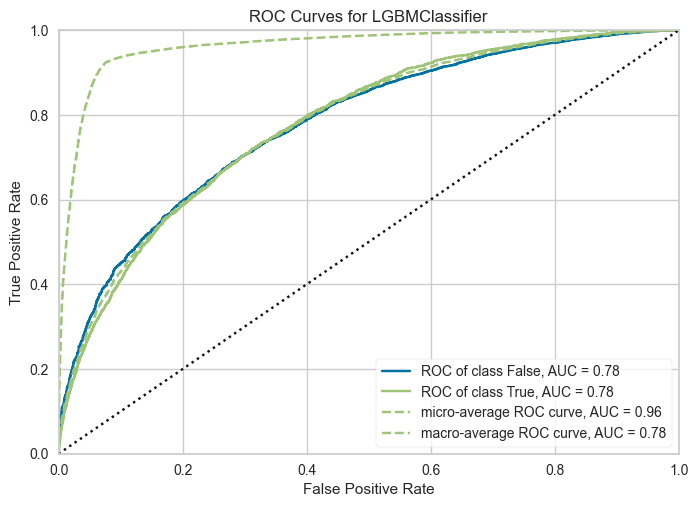

In [18]:
plot_model(tuned_gbm, plot = 'auc')

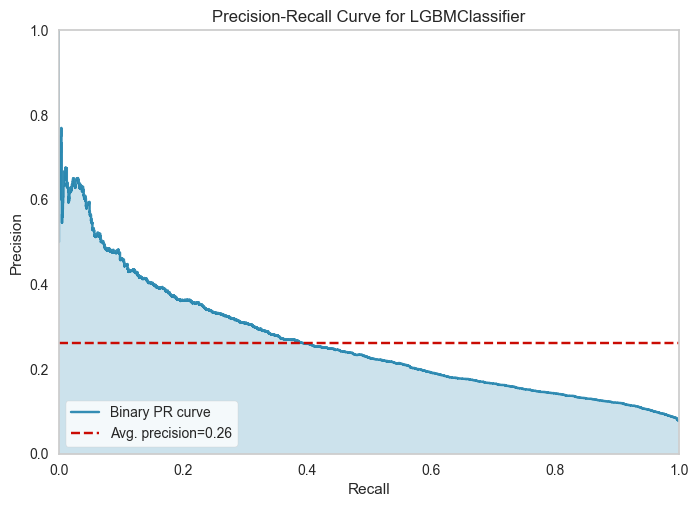

In [19]:
plot_model(tuned_gbm, plot = 'pr')

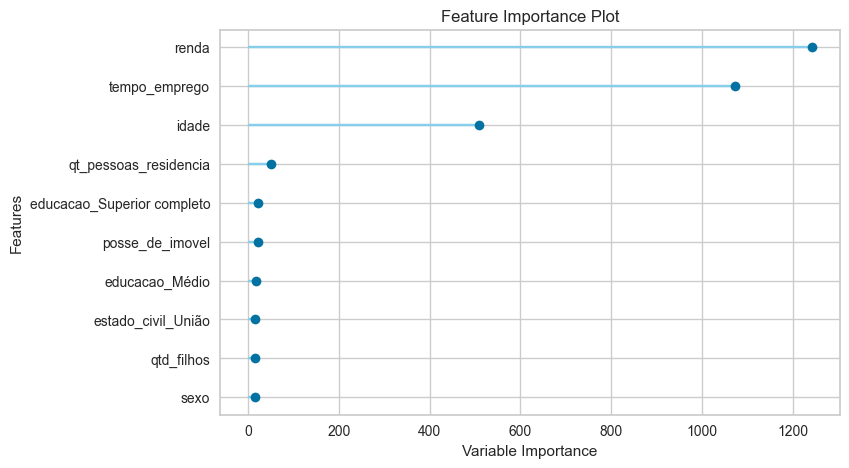

In [21]:
plot_model(tuned_gbm, plot = 'feature')

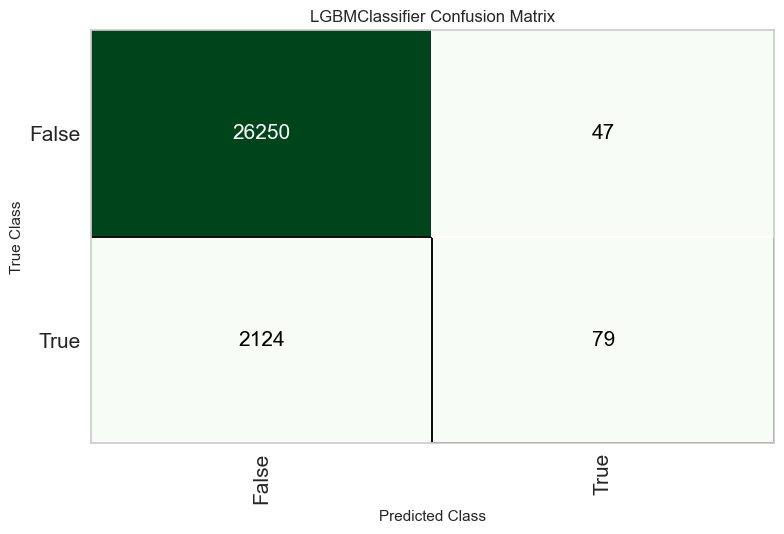

In [22]:
plot_model(tuned_gbm, plot = 'confusion_matrix')

In [24]:
evaluate_model(tuned_gbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
# Agora iremos usar o modelo treinado para prever valores do dataframe de teste.
predict_model(tuned_gbm, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9218,0.7713,0.0179,0.4667,0.0346,0.0290,0.0795


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,41,0.295890,1.0,1973.510010,False,0,0.7356
1,M,S,N,1,Empresário,Médio,Casado,Casa,44,3.838356,3.0,988.940002,False,0,0.6393
2,F,N,S,1,Assalariado,Médio,Separado,Casa,49,25.805479,2.0,36582.218750,False,0,0.9927
3,F,S,S,2,Assalariado,Superior completo,Casado,Casa,39,1.457534,4.0,6638.000000,False,0,0.9487
4,F,N,S,0,Pensionista,Médio,Viúvo,Casa,57,NaN,1.0,16917.210938,False,0,0.9779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,F,S,S,1,Assalariado,Superior completo,União,Casa,44,10.221918,3.0,7910.060059,False,0,0.9088
4996,F,S,N,0,Assalariado,Médio,Casado,Casa,53,11.134247,2.0,3101.870117,False,0,0.8518
4997,M,N,S,0,Assalariado,Médio,Casado,Casa,54,6.263014,2.0,8326.530273,False,0,0.9531
4998,F,N,S,0,Pensionista,Médio,Viúvo,Casa,61,NaN,1.0,11543.889648,False,0,0.9713


In [26]:
final_gbm = finalize_model(tuned_gbm)

In [27]:
predict_model(final_gbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9241,0.8020,0.0390,0.6466,0.0736,0.0654,0.1460


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
10783,M,S,N,0,Empresário,Médio,Casado,Casa,53,6.602740,2.0,12850.190430,False,0,0.9764
38633,F,N,N,2,Empresário,Superior completo,Casado,Casa,37,12.671233,4.0,23701.269531,False,0,0.9838
91805,F,S,S,0,Empresário,Médio,Casado,Casa,50,16.476713,2.0,104023.539062,False,0,0.9948
10620,F,S,S,0,Assalariado,Superior completo,Casado,Casa,50,2.534247,2.0,8349.709961,False,0,0.9448
83271,M,S,N,0,Assalariado,Fundamental,Casado,Casa,42,17.964384,2.0,9247.450195,False,0,0.9489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51236,F,N,N,0,Assalariado,Médio,Casado,Casa,50,3.178082,2.0,6532.560059,False,0,0.9409
64995,F,N,S,0,Pensionista,Médio,Casado,Casa,57,NaN,2.0,9281.459961,False,0,0.9590
70220,F,N,S,0,Pensionista,Médio,Separado,Casa,57,NaN,1.0,19273.859375,True,0,0.9781
64973,F,N,S,0,Assalariado,Médio,Casado,Casa,52,4.252055,2.0,18744.220703,False,0,0.9688


In [28]:
unseen_predictions = predict_model(final_gbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9214,0.7744,0.0128,0.3846,0.0248,0.0199,0.0584


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,41,0.295890,1.0,1973.510010,False,0,0.7238
1,M,S,N,1,Empresário,Médio,Casado,Casa,44,3.838356,3.0,988.940002,False,0,0.6954
2,F,N,S,1,Assalariado,Médio,Separado,Casa,49,25.805479,2.0,36582.218750,False,0,0.9916
3,F,S,S,2,Assalariado,Superior completo,Casado,Casa,39,1.457534,4.0,6638.000000,False,0,0.9444
4,F,N,S,0,Pensionista,Médio,Viúvo,Casa,57,NaN,1.0,16917.210938,False,0,0.9782


In [30]:
# Por fim iremos salvar este modelo.
save_model(final_gbm,'Final GBM Model 24Sep2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_im...
                                 boosting